# Fine-tuning

Retrain an existing model to find ring galaxies

## Setup

In [65]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import csv
import logging
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display

Importing project modules works best from the project root directory.

In [9]:
os.chdir('..')

import zoobot
import projcode
from projcode.data.utils import read_params
from projcode.finetune.finetune_minimal import FineTune

In [60]:
params = read_params()

coderoot = Path(params['coderoot'])
dataroot = Path(params['dataroot'])
csv_path = coderoot / 'data/example_ring_catalog_basic.csv'
pretrained_checkpoint = dataroot / 'results/best_training/decals/checkpoint'
save_loc = dataroot / f'results/finetune/minimal_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
save_loc.mkdir(parents=True)
logging.info(f"Output to {save_loc}")

ft = FineTune(params)
ft.setup_data(csv_path)

Logging to /home/colin/data/munch1tb/zoobot_data/logfiles/finetune.log


The ring catalog stores relative paths to the image files. This is brittle, so convert to absolute paths:

In [61]:
ft.paths_train = [str(coderoot / x) for x in ft.paths_train]
ft.paths_val = [str(coderoot / x) for x in ft.paths_val]

Convert catalog and images to a format suitable for the model.

(There seems to be a stray print statement in the zoobot code which I am still trying to find and delete.)

In [62]:
ft.preprocess_data()

[{'label': <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
      dtype=int32)>}]
[{'label': <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1],
      dtype=int32)>}]


Load the existing pretrained DECaLS model and freeze most of the layers:

In [63]:
ft.load_old_model(pretrained_checkpoint)

Train the final few layers against the ring catalog to give ring/no-ring output:

In [64]:
%time ft.retrain(save_loc)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 7, 7, 1280)        4048989   
                                                                 
 sequential_6 (Sequential)   (None, 1)                 86209     
                                                                 
Total params: 4,135,198
Trainable params: 86,209
Non-trainable params: 4,048,989
_________________________________________________________________
Epoch 1/80

 Ending step:  0.0
6/6 - 7s - loss: 0.7195 - accuracy: 0.4867 - val_loss: 0.6873 - val_accuracy: 0.5745 - 7s/epoch - 1s/step
Epoch 2/80

 Ending step:  64.0
6/6 - 3s - loss: 0.7173 - accuracy: 0.4973 - val_loss: 0.6750 - val_accuracy: 0.7340 - 3s/epoch - 446ms/step
Epoch 3/80

 Ending step:  128.0
6/6 - 3s - loss: 0.7006 - accuracy: 0.5346 - val_loss: 0.6637 - val_accuracy: 0.7713 - 3s/epoch - 449ms/step
Epoch 4/80

 En

## Predictions

First set up some file paths and get a list of full paths to PNG images:

In [80]:
predictions_loc = str(dataroot / f'predictions/finetune/minimal_{datetime.now().strftime("%Y%m%d-%H%M%S")}.csv')
# predictions_loc.mkdir(parents=True)
logging.info(f"Predictions to {predictions_loc}")

file_locs = coderoot / 'data/decals.csv'
with open(file_locs) as f:
    reader = csv.reader(f)
    png_paths = [loc[0] for loc in reader]
len(png_paths), png_paths[:3]

(272725,
 ['/home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J110/J110018.64+063254.6.png',
  '/home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J110/J110042.07+284055.0.png',
  '/home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J110/J110502.83+040421.4.png'])

Run the predictor:

In [81]:
%time ft.make_predictions(png_paths, predictions_loc)

CPU times: user 2h 16min 21s, sys: 9min 42s, total: 2h 26min 4s
Wall time: 14min 41s


In [82]:
df = pd.read_csv(predictions_loc)
df

,prediction,image_loc
0,0.605271,/home/colin/data/munch1tb/zoobot_data/gz_decal...
1,0.344280,/home/colin/data/munch1tb/zoobot_data/gz_decal...
2,0.578355,/home/colin/data/munch1tb/zoobot_data/gz_decal...
3,0.577960,/home/colin/data/munch1tb/zoobot_data/gz_decal...
4,0.528934,/home/colin/data/munch1tb/zoobot_data/gz_decal...
...,...,...
272720,0.397084,/home/colin/data/munch1tb/zoobot_data/gz_decal...
272721,0.534551,/home/colin/data/munch1tb/zoobot_data/gz_decal...
272722,0.418181,/home/colin/data/munch1tb/zoobot_data/gz_decal...
272723,0.616409,/home/colin/data/munch1tb/zoobot_data/gz_decal...


In [83]:
sorted = df.sort_values(by=['prediction'], ascending=False)
sorted.head(10)

,prediction,image_loc
206681,0.738834,/home/colin/data/munch1tb/zoobot_data/gz_decal...
59003,0.732555,/home/colin/data/munch1tb/zoobot_data/gz_decal...
19931,0.728202,/home/colin/data/munch1tb/zoobot_data/gz_decal...
40156,0.727018,/home/colin/data/munch1tb/zoobot_data/gz_decal...
53206,0.722941,/home/colin/data/munch1tb/zoobot_data/gz_decal...
195548,0.720933,/home/colin/data/munch1tb/zoobot_data/gz_decal...
79994,0.718678,/home/colin/data/munch1tb/zoobot_data/gz_decal...
197539,0.718590,/home/colin/data/munch1tb/zoobot_data/gz_decal...
29433,0.717833,/home/colin/data/munch1tb/zoobot_data/gz_decal...
126598,0.715836,/home/colin/data/munch1tb/zoobot_data/gz_decal...


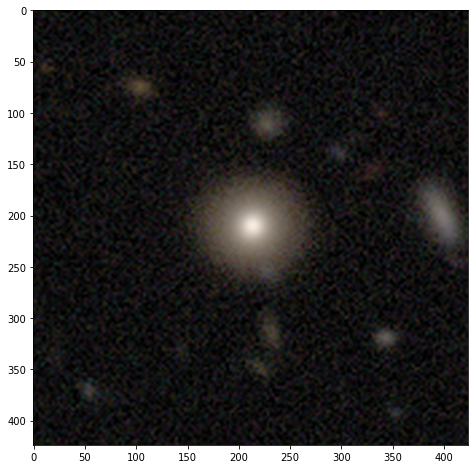

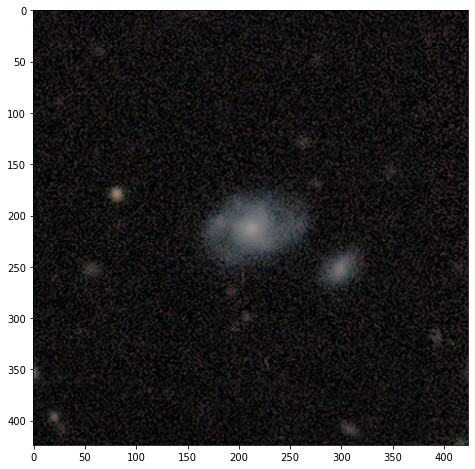

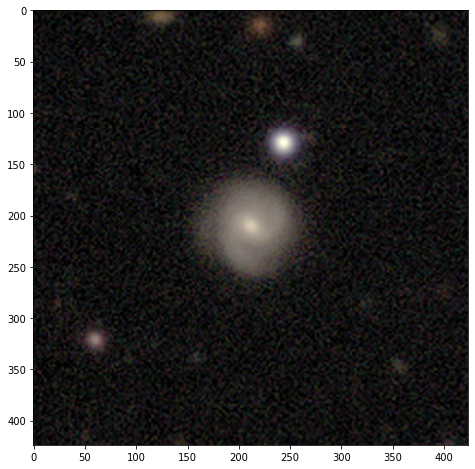

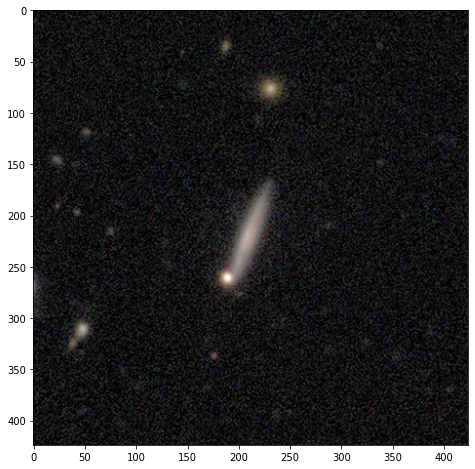

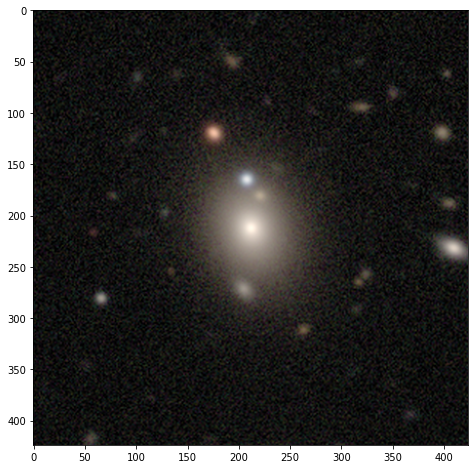

In [87]:
for n in range(5):
    file_loc = sorted['image_loc'][n]
    img = mpimg.imread(file_loc)
    fig = plt.figure(figsize=(8,8))
    imgplot = plt.imshow(img)

### Housekeeping

Create list of all DECaLS PNG files (needs postgres access)

In [76]:
# from projcode.data.db import DB
# db = DB(params)

# sql = "select path from img where survey='DECaLS_5'"
# raw = db.run_select(sql)
# paths = [str(dataroot / params['decalsdr5'] / row[0]) for row in raw]

# np.savetxt(coderoot / "data/decals.csv", 
#            paths,
#            delimiter =",", 
#            fmt ='% s')